In [1]:
import torch
import torchvision
import Dataset as D
import transform as T
from torch.utils.data import DataLoader
from validation import validation
from plot import show_hist, save_hist
from pytorch_pretrained_vit import ViT
from timm import create_model

In [2]:
lr = 1e-5
batch_size = 16

In [3]:
# dataset
img_labels = D.ImageLabels('/mnt/training_labels.txt')
dataset, val_dataset = D.get_train_val_dataset('/mnt/training_images', img_labels=img_labels,
                                               transform=T.get_transform(), val=0.3)
class_transformer = D.ClassTransform('/mnt/classes.txt')
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=32)

In [4]:
device = torch.device('cuda:0')

In [5]:
# model
model = torch.nn.Sequential(
    create_model('swin_large_patch4_window12_384', pretrained=True),
    torch.nn.Linear(1000, class_transformer.total_size),
)
model = torch.nn.DataParallel(model)
model.to(device)

DataParallel(
  (module): Sequential(
    (0): SwinTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
        (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (0): BasicLayer(
          dim=192, input_resolution=(96, 96), depth=2
          (blocks): ModuleList(
            (0): SwinTransformerBlock(
              (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
              (attn): WindowAttention(
                (qkv): Linear(in_features=192, out_features=576, bias=True)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=192, out_features=192, bias=True)
                (proj_drop): Dropout(p=0.0, inplace=False)
                (softmax): Softmax(dim=-1)
              )
              (drop_path): Identity()
              (norm2): LayerNorm((192,), eps=1e-0

In [6]:
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)

In [7]:
# loss
loss_function = torch.nn.CrossEntropyLoss()

In [8]:
# training history
train_loss, validation_loss = [], []
train_acc, validation_acc = [], []

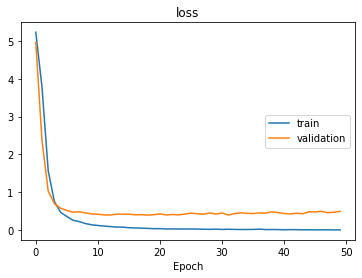

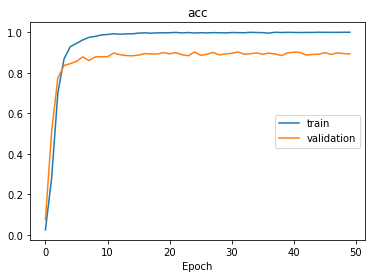

In [9]:
from IPython.display import clear_output

# training loop
epoch = 50
for i in range(epoch):
    # train
    model.train()
    loss_sum, positive, cnt = 0., 0, 0
    for labels, images in data_loader:
        y_true = torch.tensor(class_transformer.to_order(labels)).to(device)
        y_pred = model(images.to(device))

        loss = loss_function(y_pred, y_true)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # metrics
        cnt += 1
        loss_sum += loss.item()
        pre_class = class_transformer.to_class_name(y_pred)
        for ind, pre_label in enumerate(pre_class):
            if pre_label == labels[ind]:
                positive += 1

    # validation
    model.eval()
    metrics = validation(model, val_dataset, class_transformer, loss_function, device)

    # record the loss
    train_loss.append(loss_sum/cnt)
    validation_loss.append(metrics['loss'])

    # record the acc
    train_acc.append(positive / len(dataset))
    validation_acc.append(metrics['acc'])

    print('epoch', i, 'finish')
    print(metrics)

    
    clear_output()
    show_hist([train_loss, validation_loss], 'loss', ['train', 'validation'])
    show_hist([train_acc, validation_acc], 'acc', ['train', 'validation'])

In [10]:
save_hist([train_loss, validation_loss], 'loss', ['train', 'validation'])
save_hist([train_acc, validation_acc], 'acc', ['train', 'validation'])

In [11]:
torch.save(model.state_dict(), '/mnt/baseline')

In [12]:
torch.cuda.empty_cache()

In [13]:
import testing

4282.jpg 083.White_breasted_Kingfisher
1704.jpg 192.Downy_Woodpecker
2333.jpg 129.Song_Sparrow
2320.jpg 192.Downy_Woodpecker
1680.jpg 163.Cape_May_Warbler
2120.jpg 173.Orange_crowned_Warbler
3291.jpg 006.Least_Auklet
0393.jpg 123.Henslow_Sparrow
0160.jpg 039.Least_Flycatcher
3041.jpg 005.Crested_Auklet
1374.jpg 183.Northern_Waterthrush
5388.jpg 129.Song_Sparrow
3683.jpg 111.Loggerhead_Shrike
1052.jpg 111.Loggerhead_Shrike
1454.jpg 125.Lincoln_Sparrow
2560.jpg 049.Boat_tailed_Grackle
4124.jpg 152.Blue_headed_Vireo
1334.jpg 096.Hooded_Oriole
5710.jpg 083.White_breasted_Kingfisher
5256.jpg 200.Common_Yellowthroat
2398.jpg 180.Wilson_Warbler
5860.jpg 028.Brown_Creeper
5230.jpg 118.House_Sparrow
3131.jpg 163.Cape_May_Warbler
2941.jpg 099.Ovenbird
2696.jpg 055.Evening_Grosbeak
5137.jpg 163.Cape_May_Warbler
5550.jpg 036.Northern_Flicker
0513.jpg 120.Fox_Sparrow
0467.jpg 097.Orchard_Oriole
0286.jpg 059.California_Gull
4749.jpg 117.Clay_colored_Sparrow
2386.jpg 062.Herring_Gull
2238.jpg 009.Bre